In [68]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 20 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.zeros(2*num_steps)
z0 = np.ones(2*num_steps) * (np.pi) / (dt*num_steps)

parameter_list = list(zip(x0,z0))
num_params = len(parameter_list[0])

In [69]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s


In [70]:
# --- Define parametrized system ----------------------------------------------

def get_hamiltonian_discrete():
    """
    Returns a callable which takes a set of parameters for a given time and returns the corresponding Hamiltonian

    """
    def hamiltonian(hx,hz):

        hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
        hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

        return hz_sz + hx_sx
    
    return hamiltonian

parametrized_system = oqupy.ParameterizedSystem(get_hamiltonian_discrete())

# --- Compute fidelity, dynamics, and fidelity gradient -----------------------

from oqupy.gradient import state_gradient

fidelity_dict = oqupy.state_gradient(
                system=parametrized_system,
                initial_state=initial_state,
                target_state=target_state,
                process_tensor=process_tensor,
                parameters=parameter_list,
                return_dynamics=True,
                return_fidelity=True)


total_derivs_x = np.array([parameter[0] for parameter in fidelity_dict['gradient']])
total_derivs_z = np.array([parameter[1] for parameter in fidelity_dict['gradient']])

--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
21


the fidelity is (0.9198983875526694+5.90550368830208e-16j)
the fidelity gradient is [[ 2.42731992e-04-1.84788708e-17j -1.45174671e-16-5.36253171e-16j]
 [-8.55533871e-17-4.88609589e-19j -1.45283091e-16-5.36232842e-16j]
 [ 4.71082653e-04-5.45828031e-17j -1.45716772e-16-5.37933684e-16j]
 [ 2.39729661e-04-3.34747421e-17j -1.45716772e-16-5.37920132e-16j]
 [ 6.61727323e-04-7.37799578e-17j -1.43548368e-16-5.38821375e-16j]
 [ 4.59206461e-04-7.25263491e-17j -1.43656788e-16-5.38807822e-16j]
 [ 7.94521571e-04-7.91535349e-17j -1.41922064e-16-5.39627750e-16j]
 [ 6.35752669e-04-8.79457368e-17j -1.42030485e-16-5.40488336e-16j]
 [ 8.54840653e-04-1.06360233e-16j -1.44740990e-16-5.39573540e-16j]
 [ 7.50419778e-04-9.19911662e-17j -1.44740990e-16-5.40434125e-16j]
 [ 8.35060008e-04-1.30714124e-16j -1.48318857e-16-5.38814598e-16j]
 [ 7.90206571e-04-1.15027074e-16j -1.48318857e-16-5.38814598e-16j]
 [ 7.35293894e-04+3.56431464e-18j -1.47343075e-16-5.43266604e-16j]
 [ 7.49376543e-04-1.36423126e-16j -1.47451495

c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


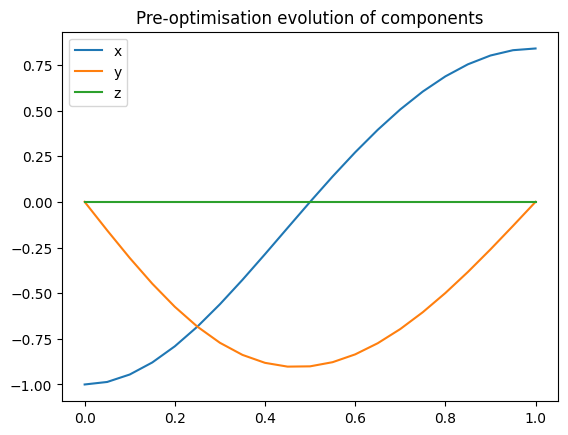

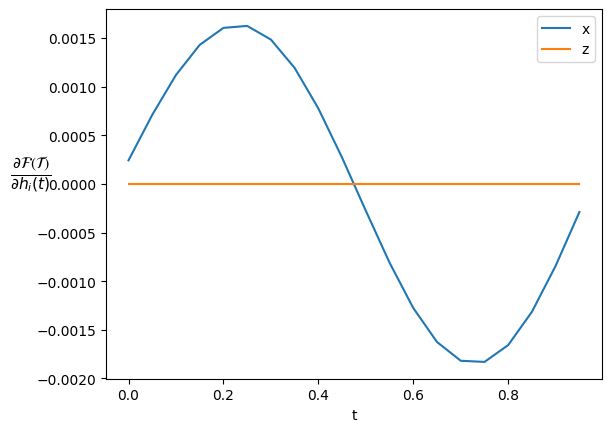

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


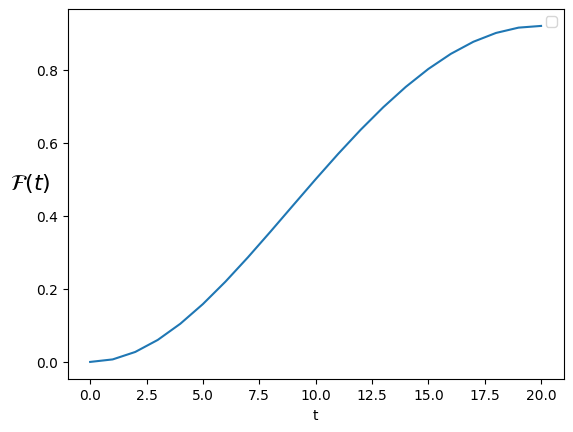

In [71]:
from scipy.linalg import sqrtm


# --- Fidelity Gradient results ------

print(f"the fidelity is {fidelity_dict['fidelity']}")
print(f"the fidelity gradient is {fidelity_dict['gradient']}")

# ----------- Initial Dynamics on Bloch sphere -------------
t, s_x = fidelity_dict['dynamics'].expectations(op.sigma("x"))
t, s_y = fidelity_dict['dynamics'].expectations(op.sigma("y"))
t, s_z = fidelity_dict['dynamics'].expectations(op.sigma("z"))

plt.title("Pre-optimisation evolution of components")

plt.plot(t,s_x,label='x')
plt.plot(t,s_y,label='y')
plt.plot(t,s_z,label='z')

plt.legend()
plt.show()

# ----- Fidelity Gradient Graph --------

def sum_adjacent_elements(list:List)->List:

    half_the_size = len(list) / 2
    assert (half_the_size).is_integer(), \
        'if one output from both pre and post node is given, result must be even'
    half_the_size = int(half_the_size)

    summed_array = np.reshape(list,(half_the_size,2)).sum(axis=1)
    return summed_array


final_derivs_x = sum_adjacent_elements(total_derivs_x)
final_derivs_z = sum_adjacent_elements(total_derivs_z)


plt.plot(t[:-1],final_derivs_x,label='x')
plt.plot(t[:-1],final_derivs_z,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F(T)}}{\partial h_i (t)}$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

# Fidelity Graph 
dynamics = fidelity_dict['dynamics']
fidelity=[]

for state in dynamics.states:
    sqrt_final_state = sqrtm(state)
    intermediate_1 = sqrt_final_state @ target_state
    inside_of_sqrt = intermediate_1 @ sqrt_final_state
    fidelity.append((sqrtm(inside_of_sqrt).trace())**2)

plt.plot(fidelity)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")

plt.legend()
plt.show()


In [72]:

# ----------- Optimisation of control parameters w.r.t. infidelity ---------------

def flatten_list(parameter_list):
    assert np.shape(parameter_list) == (2*process_tensor.__len__(),num_params)
    parameter_list_flat = [
    x
    for xs in parameter_list
    for x in xs
    ]
    print(np.shape(parameter_list_flat))
    return parameter_list_flat

def unflatten_list(flat_list):
    assert np.shape(flat_list) == (2*num_params*process_tensor.__len__(),)
    parameter_list = np.reshape(flat_list,(2*process_tensor.__len__(),num_params))
    return parameter_list

def sum_adjacent_elements(list:List)->List:
    # maybe this goes in helpers.py or utils.py?
    half_the_size = len(list) / 2
    assert (half_the_size).is_integer(), \
        'if one output from both pre and post node is given, result must be even'
    half_the_size = int(half_the_size)

    # https://stackoverflow.com/a/29392016
    summed_array = np.reshape(list,(half_the_size,2)).sum(axis=1)
    return summed_array

def infidelity(parameter_list_flat):

    parameter_list_var = unflatten_list(parameter_list_flat)

    return_dict = state_gradient(system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=parameter_list_var,
        return_fidelity=True,
        return_dynamics=False)
    
    return 1-float(return_dict['fidelity'].real)

def fidelity_jacobian(parameter_list_flat):

    parameter_list_var = unflatten_list(parameter_list_flat)

    fidelity_dict = state_gradient(
        system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=parameter_list_var)
    
    fidelity_jacobian = flatten_list(fidelity_dict['gradient'])

    fidelity_jacobian = sum_adjacent_elements(fidelity_jacobian)

    piecewiseconst_jacobian = [0]*num_steps*2*num_params

    for i,element in enumerate(fidelity_jacobian):
        piecewiseconst_jacobian[2*i] = fidelity_jacobian[i]
        piecewiseconst_jacobian[2*i+1] = fidelity_jacobian[i]

    fort_jac =np.asfortranarray(piecewiseconst_jacobian)

    return -fort_jac

In [73]:
#x_bound = [-5,5]
#z_bound = [-1,1]
#bounds = np.zeros((2*num_steps*num_params,2))

#for i in range(0, 2*num_params*num_steps,2):
    #bounds[i] = x_bound
    #bounds[i+1] = z_bound

bounds = Bounds(lb=-5,ub=5)

optimization_result = minimize(
                        fun=infidelity,
                        x0=flatten_list(parameter_list),
                        method='L-BFGS-B',
                        jac=fidelity_jacobian,
                        bounds=bounds,
                        callback=infidelity,
                        options = {'disp':True}
)



(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
(80,)


c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  g = g.astype(np.float64)


The maximal fidelity was found to be :  -0.04494156221659906
The jacobian was found to be :  [-0.00073294 -0.00073294 -0.0006675  -0.0006675  -0.00073045 -0.00073045
 -0.00066182 -0.00066182 -0.0007261  -0.0007261  -0.00067016 -0.00067016
 -0.00070246 -0.00070246 -0.00067645 -0.00067645 -0.00064704 -0.00064704
 -0.00066116 -0.00066116 -0.00055935 -0.00055935 -0.00061335 -0.00061335
 -0.00045697 -0.00045697 -0.000537   -0.000537   -0.0003575  -0.0003575
 -0.00044849 -0.00044849 -0.00027384 -0.00027384 -0.00036259 -0.00036259
 -0.00021224 -0.00021224 -0.00028904 -0.00028904 -0.00017387 -0.00017387
 -0.00023233 -0.00023233 -0.00015758 -0.00015758 -0.00019292 -0.00019292
 -0.00016235 -0.00016235 -0.00017095 -0.00017095 -0.00018857 -0.00018857
 -0.00016769 -0.00016769 -0.00023948 -0.00023948 -0.00018668 -0.00018668
 -0.00032302 -0.00032302 -0.00023462 -0.00023462 -0.00045259 -0.00045259
 -0.00032235 -0.00032235 -0.0006448  -0.0006448  -0.00046504 -0.00046504
 -0.00090237 -0.00090237 -0.0006

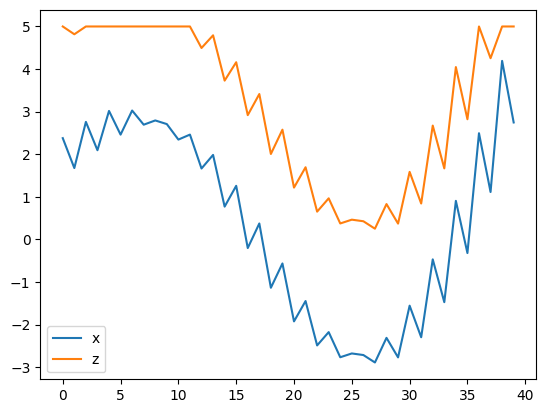

--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.0s
21
the fidelity is (0.9550584431410724-5.49815926478404e-10j)
the fidelity gradient is [[-5.72656563e-05+1.02931444e-16j  7.90203946e-04-3.48869154e-16j]
 [-6.80782630e-05-4.99241219e-18j  7.35577130e-04-4.30008134e-16j]
 [-1.79688419e-04-1.61139548e-16j  9.10141174e-04-3.64806926e-16j]
 [-1.86526139e-04-5.96988821e-17j  8.48347901e-04-4.09909736e-16j]
 [-3.10011933e-04-1.44876515e-16j  1.03611037e-03-2.65954793e-16j]
 [-3.02311447e-04-2.11256793e-16j  9.72468116e-04-3.14879416e-16j]
 [-4.50996531e-04-6.01732206e-17j  1.15346021e-03-3.12467066e-16j]
 [-4.19392996e-04-1.61437703e-16j  1.09584094e-03-3.27483266e-16j]
 [-6.00762105e-04-6.77626358e-19j  1.24780710e-03-4.57438449e-16j]
 [-5.42376673e-04-3.79199710e-17j  1.20354089e-03-1.95888228e-16j]
 [-7.50073762e-04+3.17400186e-17j  1.30942021e-03-4.04895301e-16j]
 [-6.69346652e-04+1.59106669e-17j  1.28269921e-03-3.10190242e-1

c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Administrator\Desktop\Research\OQuPy\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


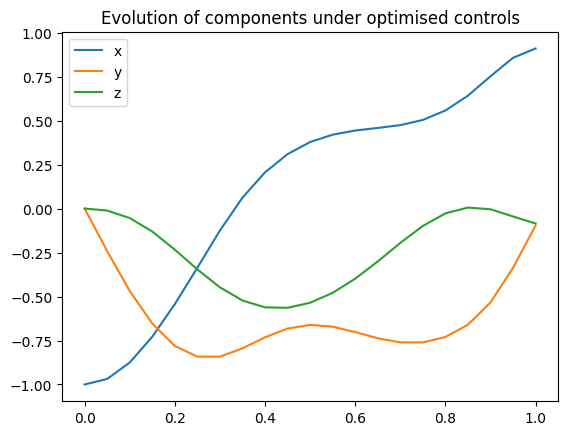

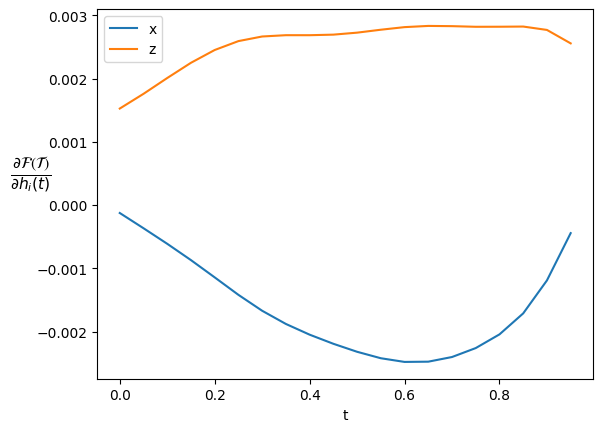

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


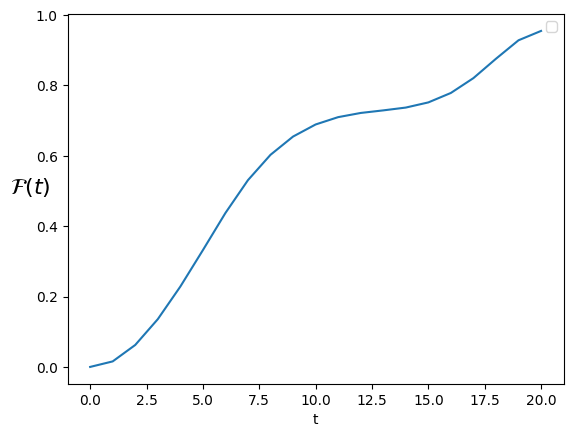

In [74]:

print("The maximal fidelity was found to be : ",-optimization_result.fun)

print("The jacobian was found to be : ",optimization_result.jac)

optimized_parameters_flat = optimization_result.x

times = np.arange(0,2*num_steps)
optimized_parameters = unflatten_list(optimized_parameters_flat)

opt_params_x = np.array([parameter[0] for parameter in optimized_parameters])
opt_params_z = np.array([parameter[1] for parameter in optimized_parameters])

plt.plot(times,opt_params_x,label='x')
plt.plot(times,opt_params_z,label='z')

plt.legend()
plt.show()

optimized_dynamics = state_gradient(
        system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=optimized_parameters,
        return_fidelity=True,
        return_dynamics=True)

# --- Optimised Fidelity Gradient results ------

print(f"the fidelity is {optimized_dynamics['fidelity']}")
print(f"the fidelity gradient is {optimized_dynamics['gradient']}")

# ----------- Optimised Dynamics on Bloch sphere -------------
t, s_x = optimized_dynamics['dynamics'].expectations(op.sigma("x"))
t, s_y = optimized_dynamics['dynamics'].expectations(op.sigma("y"))
t, s_z = optimized_dynamics['dynamics'].expectations(op.sigma("z"))

plt.title("Evolution of components under optimised controls")

plt.plot(t,s_x,label='x')
plt.plot(t,s_y,label='y')
plt.plot(t,s_z,label='z')

plt.legend()
plt.show()

# ----- Fidelity Gradient Graph --------

opt_derivs_x = np.array([parameter[0] for parameter in optimized_dynamics['gradient']])
opt_derivs_z = np.array([parameter[1] for parameter in optimized_dynamics['gradient']])


final_opt_derivs_x = sum_adjacent_elements(opt_derivs_x)
final_opt_derivs_z = sum_adjacent_elements(opt_derivs_z)


plt.plot(t[:-1],final_opt_derivs_x,label='x')
plt.plot(t[:-1],final_opt_derivs_z,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F(T)}}{\partial h_i (t)}$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

# Optimised Fidelity Graph 
dynamics = optimized_dynamics['dynamics']
fidelity=[]

for state in dynamics.states:
    sqrt_final_state = sqrtm(state)
    intermediate_1 = sqrt_final_state @ target_state
    inside_of_sqrt = intermediate_1 @ sqrt_final_state
    fidelity.append((sqrtm(inside_of_sqrt).trace())**2)

plt.plot(fidelity)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")

plt.legend()
plt.show()
